# Final Project: Miguel Habana
Assigned sound: xserra/sounds/162045/

## Part I: Analysis

In [204]:
import numpy as np
import os, sys
import json

import matplotlib.pyplot as plt
import IPython.display as ipd

from scipy.signal import get_window

sys.path.append('../software/models/')
sys.path.append('../software/transformations/')
import utilFunctions as UF
import stft as STFT
import hprModel as HPR
import harmonicModel as HM

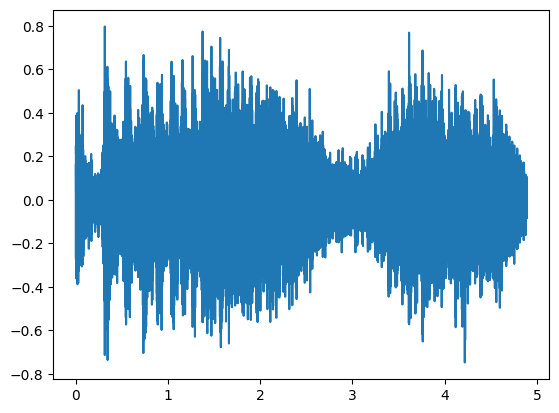

In [169]:
# 1. Read the downloaded/edited sound and display it

input_file = '../sounds/beijing-opera.wav'
(fs, x) = UF.wavread(input_file)

n_samples = len(x)
sampling_period = 1/fs
time_axis = [i*sampling_period for i in range(n_samples)]

plt.plot(time_axis, x)
ipd.display(ipd.Audio(data=x, rate=fs))

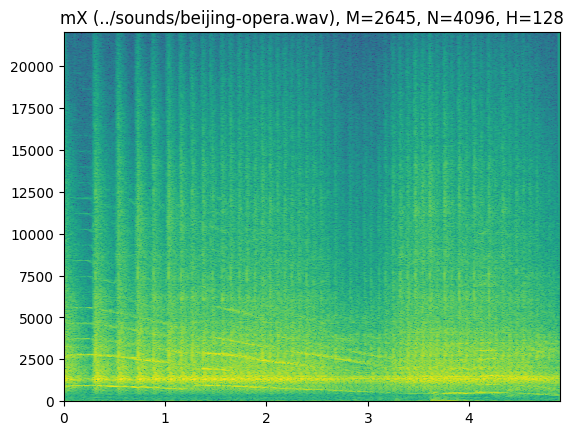

In [183]:
# 2. Compute its STFT and show the magnitude spectrogram

input_file = '../sounds/beijing-opera.wav'
window = 'blackman'
M = 2645
N = 4096
H = 128

w = get_window(window, M)

mX, pX = STFT.stftAnal(x, w, N, H)

numFrames = mX.shape[0]
frmTime = H*np.arange(numFrames)/float(fs)
binFreq = np.arange(mX.shape[1])*float(fs)/N
plt.pcolormesh(frmTime, binFreq, np.transpose(mX))
plt.title('mX ({0}), M={1}, N={2}, H={3}'.format(input_file, M, N, H))
plt.autoscale(tight=True)

In [184]:
# 3.  Explain the edits you did on the original sound given and explain why you choose this sound fragment

Explaination = """
The first edit that was performed on the original sound was to convert it from a stereo file to a mono file.
To do this we split the track by the two channels and selected the second channel to be used as a mono file.
The second channel was selected because there was less clipping on the sound but only very minimally, both
channels had really good quality but this slight difference was enough to consider the second channel over the first.as_integer_ratio

Another modification that was performed on the track was to trim it to below 5s, since the original track was over 20s.
To do this we selected the portion of the track starting from 10.156s until 15.045s as our sample sound. This portion
of the sound was selected because it had the most percussive attacks that were overlapped with a vocal sound.
The first 10s of the sound were simply vocals, and would not be interesting for what I wanted to do for the
second part which was to improve the HPR model for onset detection on the percussive portions. Then the last 5s
the percussions were too far apart and did not contain any vocals so it would not be as interesting to see the
result using an improved HPR model.
"""

Text(0.5, 1.0, 'magnitude spectrogram')

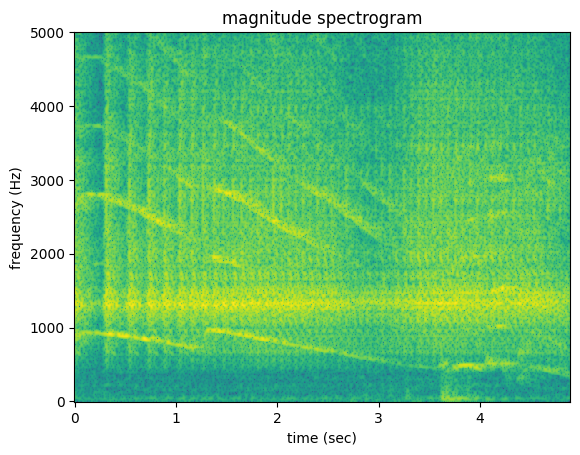

In [185]:
# 4. Describe the sound by using its temporal and spectral representation, focusing on what information should be useful for processing the sound with spectral models, thus for deciding the spectral analysis parameters
# 5. Show any partial representation, temporal or spectral, of the sound to support your description.

"""
We can examine the midrange frequency band of 300 Hz to 5,000 Hz for us to examine the harmonics of the vocal components of the sound sample.
Since the percussive components wont appear as harmonics we should be able to easily identify the harmonic components in between the percussive
strikes that should show up as linear bars in the magnitude spectrum
"""

maxplotfreq = 5000.0
numFrames = int(mX[:,0].size)
frmTime = H*np.arange(numFrames)/float(fs)
binFreq = fs*np.arange(N*maxplotfreq/fs)/N
plt.pcolormesh(frmTime, binFreq, np.transpose(mX[:,:int(N*maxplotfreq/fs+1)]))
plt.xlabel('time (sec)')
plt.ylabel('frequency (Hz)')
plt.title('magnitude spectrogram')

Text(0.5, 1.0, 'magnitude spectrogram')

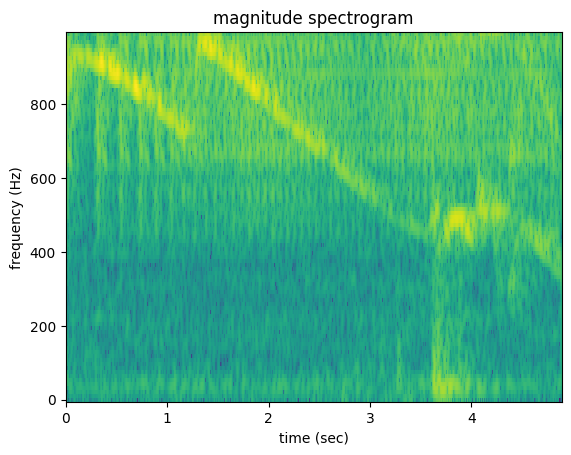

In [187]:
"""
Examining the harmonic structure of the sound in the midrange frequencies we can see that the fundamental frequency of the vocal component is somewhere below
1000 Hz. By reducing the maximum range for our analysis to 1000 Hz we can try to identify the frequency thresholds for the fundamental frequency to be used 
in our harmonic model.
"""

maxplotfreq = 1000.0
numFrames = int(mX[:,0].size)
frmTime = H*np.arange(numFrames)/float(fs)
binFreq = fs*np.arange(N*maxplotfreq/fs)/N
plt.pcolormesh(frmTime, binFreq, np.transpose(mX[:,:int(N*maxplotfreq/fs+1)]))
plt.xlabel('time (sec)')
plt.ylabel('frequency (Hz)')
plt.title('magnitude spectrogram')

In [ ]:
"""
With the analysis we've identified the frequency range of the fundamental frequency of the vocal component to be between 350 Hz to 1000 Hz. Using this
we can start to analyze the sound using the HPR model to further investigate the residual component of the sound to learn more about the percussive
components and see how we can further improve the analysis for better onset detection.
"""

# Part II (option a): Enhanced Sound Modelling

In [203]:
window = 'blackman'
t = -90
M = 601
w = get_window(window, M)
N = 1024
H = 128
nH = 100
minf0 = 350
maxf0 = 1000
f0et = 5
minSineDur = 0.1
harmDevSlope = 0.05

hfreq, hmag, hphase, xr = HPR.hprModelAnal(x, fs, w, N, H, t, minSineDur, nH, minf0, maxf0, f0et, harmDevSlope)

"""
Explaination of chosen HPR parameters:

Window: Blackman
- The blackman window was chosen to be able to mitigate the effects of the side lobes since it has one of the lower side lobe heights. Then it was selected over
the blackman-harris window because it has a narrower main lobe width, to be able to select a smaller window size and get a higher spectral resultion from the
resulting analysis.

Magnitude Threshold: -90 dB
- This was selected to reduce the effects of the side lobes of the blackman window.

Window Size: 601
- Based on the fundamental frequency of the vocal components we can calculate the desired window size as 6 (blackman bin width) * 44100 (sampling rate) / 500 (relative fundamental frequency of the vocal component).
This computation results in a suggested window size of 529. Then in order to improve the frequency resolution and provide a smoother approximation of the frequencies in the magnitude spectrum we can 
increase our window size by a bit to 601, and retain an odd window size.

FFT Size: 1024
- We select the FFT size that is the next power of 2 larger than our window size.

Hop Size: 128
- We select a small hop size of 128 to attain a good temporal and spectral resolution as a smaller hop size results in a better result for both. Then the choice of 128 also results in around a 20% overlap with our
window size choice.

minf0 and maxf0: 350 and 1000
- We select these two values as our f0 range because of our previous analysis that the fundamental frequency components of the voice are found within this range for the audio sample we are analyzing.

f0et: 5
- Select a generous f0et parameter since there is a lot of variation in the fundamental frequency as well as the noise generated by the percussive components can affect the harmonic detection so we 
choose a fairly big f0et parameter to allow the analysis to work around these caveats.

minSineDur: 0.1
- We select a minimum duration of 0.1 to account for the short vocal phrases in some portions of the sample.

harmDevSlope: 0.05
- We select a devSlope of 0.05 to account for the rapid downward frequency changes in the first two vocal components.
"""

'\nExplaination of chosen HPR parameters:\n\nWindow: Blackman\n- The blackman window was chosen to be able to mitigate the effects of the side lobes since it has one of the lower side lobe heights. Then it was selected over\nthe blackman-harris window because it has a narrower main lobe width, to be able to select a smaller window size and get a higher spectral resultion from the\nresulting analysis.\n\nMagnitude Threshold: -90 dB\n- This was selected to reduce the effects of the side lobes of the blackman window.\n\nWindow Size: 601\n- Based on the fundamental frequency of the vocal components we can calculate the desired window size as 6 (blackman bin width) * 44100 (sampling rate) / 500 (relative fundamental frequency of the vocal component).\nThis computation results in a suggested window size of 529. Then in order to improve the frequency resolution and provide a smoother approximation of the frequencies in the magnitude spectrum we can \nincrease our window size by a bit to 601, 

In [194]:
mXr, pXr = STFT.stftAnal(xr, w, N, H)

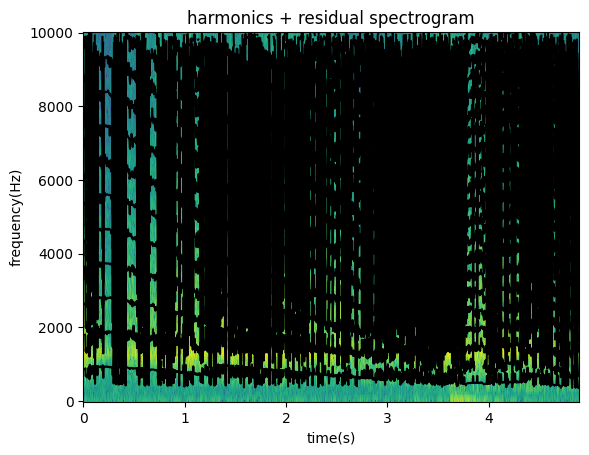

In [199]:
maxplotfreq = 10000

maxplotbin = int(N*maxplotfreq/fs)
numFrames = int(mXr[:,0].size)
frmTime = H*np.arange(numFrames)/float(fs)
binFreq = np.arange(maxplotbin+1)*float(fs)/N
plt.pcolormesh(frmTime, binFreq, np.transpose(mXr[:,:maxplotbin+1]))
plt.autoscale(tight=True)

# plot harmonic frequencies on residual spectrogram
if (hfreq.shape[1] > 0):
    harms = hfreq*np.less(hfreq,maxplotfreq)
    harms[harms==0] = np.nan
    numFrames = int(harms[:,0].size)
    frmTime = H*np.arange(numFrames)/float(fs)
    plt.plot(frmTime, harms, color='k', ms=3, alpha=1)
    plt.xlabel('time(s)')
    plt.ylabel('frequency(Hz)')
    plt.autoscale(tight=True)
    plt.title('harmonics + residual spectrogram')

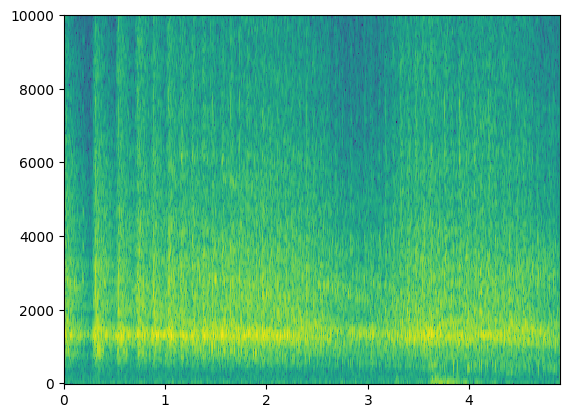

In [202]:
maxplotbin = int(N*maxplotfreq/fs)
numFrames = int(mXr[:,0].size)
frmTime = H*np.arange(numFrames)/float(fs)
binFreq = np.arange(maxplotbin+1)*float(fs)/N
plt.pcolormesh(frmTime, binFreq, np.transpose(mXr[:,:maxplotbin+1]))
plt.autoscale(tight=True)

ipd.display(ipd.Audio(data=xr, rate=fs))

Based on our analysis from the first part we can see that using the HPR model to remove the harmonic components (the voice) from the sound results in good representation of the percussive components by using the residual component. Although after examining the the resulting magnitude spectrum a better analysis could be made by using different analysis parameters for the STFT of the residual. Additionally, using a filter to filter out the lower frequency components to remove additional noise could prove useful for the onset detection. Since the percussive components are sustained even in the higher frequencies we can try to remove some of the noise in the lower frequencies by filtering them out and the result of the filter would be good for our analysis for the onset detection. Lastly another improvement that we could make is to compute the energy envelope of the output after the filter for it to be used as our final analysis component for the onset detection.

In [420]:
from scipy.signal import butter, lfilter

def butter_lowpass(cutoff_freq, sampling_rate, order=4):
    nyquist = 0.5 * sampling_rate
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def apply_filter(data, b, a):
    y = lfilter(b, a, data)
    return y

def hprModelAnal_odf_modified(x, fs, w, N, H, t, minSineDur, nH, minf0, maxf0, f0et, harmDevSlope, stft_w, stft_N, stft_H):
    
    # apply HPR model and get the residual
    hfreq, hmag, hphase = HM.harmonicModelAnal(x, fs, w, N, H, t, nH, minf0, maxf0, f0et, harmDevSlope, minSineDur)
    Ns = 512
    xr = UF.sineSubtraction(x, Ns, H, hfreq, hmag, hphase, fs)
    
    # apply a bandpass filter on the residual to reduce the noise in the lower frequencies
    a,b = butter_lowpass(4000, fs, 1)
    y = apply_filter(xr, b, a)

    # apply a STFT to the filtered residual
    mY, pY = STFT.stftAnal(y, stft_w, stft_N, stft_H)

    y = STFT.stftSynth(mY, pY, M, H)


    # apply an onset detection function
    def odf(eg):
        o = eg - np.roll(eg, 1)
        o[0] = 0
        o[o <= 8] = 0
        return o

    border_bin = int(np.ceil(float(3000) * N / fs))
    max_bin = int(np.ceil(float(10000) * N / fs))

    low = np.transpose(np.transpose(mY)[1:border_bin])
    high = np.transpose(np.transpose(mY)[border_bin:max_bin])
    
    e_low = 10 * np.log10(np.sum((10 ** (low / 20)) ** 2, axis=1))
    e_high = 10 * np.log10(np.sum((10 ** (high / 20)) ** 2, axis=1))

    # combine the energy computation of the lows and highs since we were able to filter out the noise
    # the total energy of both the high and low bands should be equivalent to the entire percussive attack
    e_total = e_low + e_high
    
    odf_total = odf(e_total)
    
    odfs = np.transpose(odf_total)


    # plot the analysis of the onset detection function
    plt.figure(1, figsize=(9.5, 6))

    plt.subplot(211)
    numFrames = mY.shape[0]
    frmTime = H*np.arange(numFrames)/float(fs)
    binFreq = np.arange(mY.shape[1])*float(fs)/N
    plt.pcolormesh(frmTime, binFreq, np.transpose(mY))
    plt.title('mY ({0}), M={1}, N={2}, H={3}'.format(input_file, M, N, H))
    plt.autoscale(tight=True)
    
    plt.plot(frmTime, odf_total*1000, color="red", label="high")
    plt.title('Onset Detection')
    plt.autoscale(tight=True)

    plt.subplot(212)
    plt.plot(frmTime, e_total, color='green', label="total")
    plt.title('Energy of Envelopes')
    plt.autoscale(tight=True)

    plt.tight_layout()
    plt.show()

    return y, mY, odfs

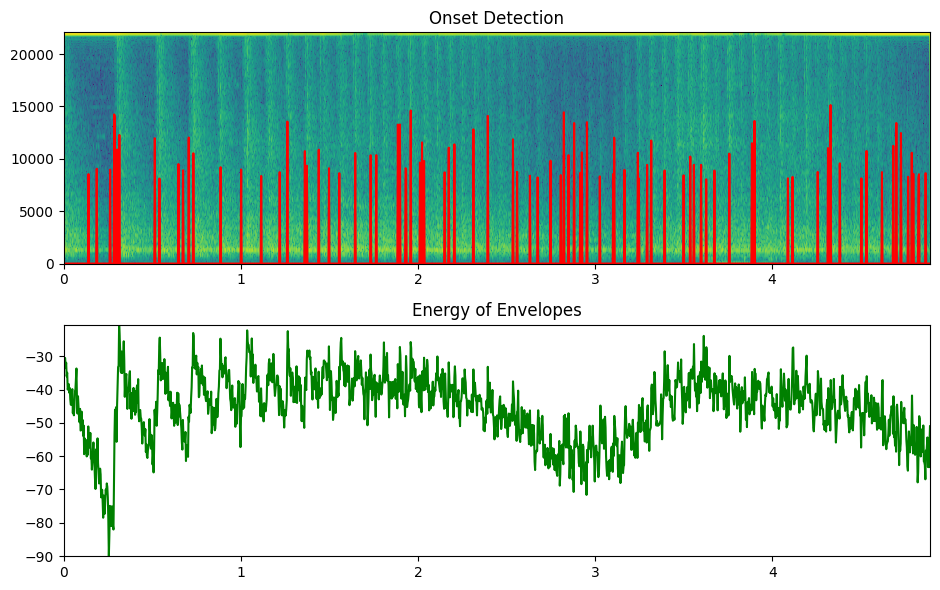

In [421]:
window = 'blackman'
t = -90
M = 601
w = get_window(window, M)
N = 1024
H = 128
nH = 100
minf0 = 350
maxf0 = 1000
f0et = 5
minSineDur = 0.1
harmDevSlope = 0.05
stft_w = get_window(window, 301)

# apply half the window function for the STFT analysis to get sharper and clearer attacks for the onset detection
y, mY, odfs = hprModelAnal_odf_modified(x, fs, w, N, H, t, minSineDur, nH, minf0, maxf0, f0et, harmDevSlope, stft_w, N, H)

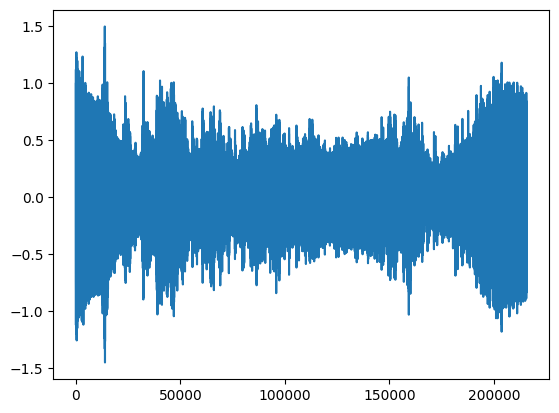

In [417]:
plt.plot(y)

### Modified residual result

In [408]:
ipd.display(ipd.Audio(data=y, rate=fs))

### Original residual result

In [409]:
ipd.display(ipd.Audio(data=xr, rate=fs))

Because of the lower window size for the STFT analysis the attacks of the modified residual result are much clearer in comparison to the original residual. We can also notice that there is less white noise in the lower frequencies of the modified residual in comparison to the original residual which also results in a more perceptually pronounced attack for all the percussive strikes

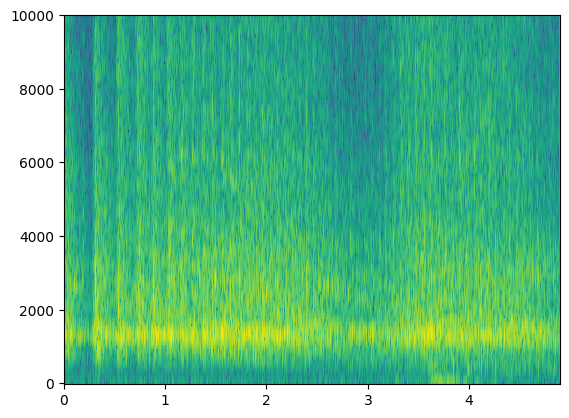

In [410]:
maxplotbin = int(N*maxplotfreq/fs)
numFrames = int(mY[:,0].size)
frmTime = H*np.arange(numFrames)/float(fs)
binFreq = np.arange(maxplotbin+1)*float(fs)/N
plt.pcolormesh(frmTime, binFreq, np.transpose(mY[:,:maxplotbin+1]))
plt.autoscale(tight=True)

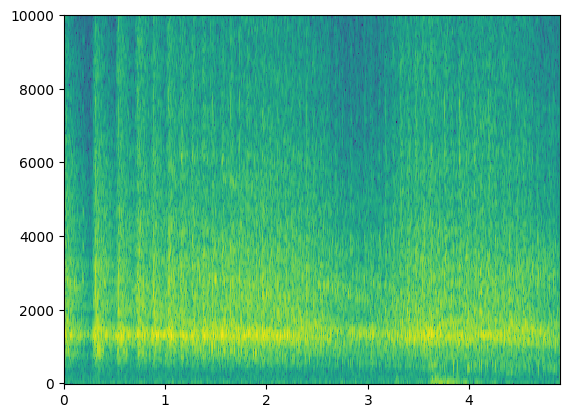

In [411]:
maxplotbin = int(N*maxplotfreq/fs)
numFrames = int(mXr[:,0].size)
frmTime = H*np.arange(numFrames)/float(fs)
binFreq = np.arange(maxplotbin+1)*float(fs)/N
plt.pcolormesh(frmTime, binFreq, np.transpose(mXr[:,:maxplotbin+1]))
plt.autoscale(tight=True)

In [430]:
def hprModelAnal_odf_normal(x, fs, w, N, H, t, minSineDur, nH, minf0, maxf0, f0et, harmDevSlope):
    
    # apply HPR model and get the residual
    hfreq, hmag, hphase = HM.harmonicModelAnal(x, fs, w, N, H, t, nH, minf0, maxf0, f0et, harmDevSlope, minSineDur)
    Ns = 512
    xr = UF.sineSubtraction(x, Ns, H, hfreq, hmag, hphase, fs)

    # apply a STFT to the filtered residual
    mY, pY = STFT.stftAnal(xr, w, N, H)


    # apply an onset detection function
    def odf(eg):
        o = eg - np.roll(eg, 1)
        o[0] = 0
        o[o <= 6] = 0
        return o

    border_bin = int(np.ceil(float(3000) * N / fs))
    max_bin = int(np.ceil(float(10000) * N / fs))

    low = np.transpose(np.transpose(mY)[1:border_bin])
    high = np.transpose(np.transpose(mY)[border_bin:max_bin])
    
    e_low = 10 * np.log10(np.sum((10 ** (low / 20)) ** 2, axis=1))
    e_high = 10 * np.log10(np.sum((10 ** (high / 20)) ** 2, axis=1))

    # combine the energy computation of the lows and highs since we were able to filter out the noise
    # the total energy of both the high and low bands should be equivalent to the entire percussive attack
    e_total = e_low + e_high
    
    odf_total = odf(e_total)
    
    odfs = np.transpose(odf_total)


    # plot the analysis of the onset detection function
    plt.figure(1, figsize=(9.5, 6))

    plt.subplot(211)
    numFrames = mX.shape[0]
    frmTime = H*np.arange(numFrames)/float(fs)
    binFreq = np.arange(mX.shape[1])*float(fs)/N
    plt.pcolormesh(frmTime, binFreq, np.transpose(mX))
    plt.title('mX ({0}), M={1}, N={2}, H={3}'.format(input_file, M, N, H))
    plt.autoscale(tight=True)
    
    plt.plot(frmTime, odf_total*5000, color="red", label="high")
    plt.title('Onset Detection')
    plt.autoscale(tight=True)

    plt.subplot(212)
    plt.plot(frmTime, e_total, color='green', label="total")
    plt.title('Energy of Envelopes')
    plt.autoscale(tight=True)

    plt.tight_layout()
    plt.show()

    return y, mY, odfs

### Normal results without the low pass filter and unique STFT parameters for the residual transformation

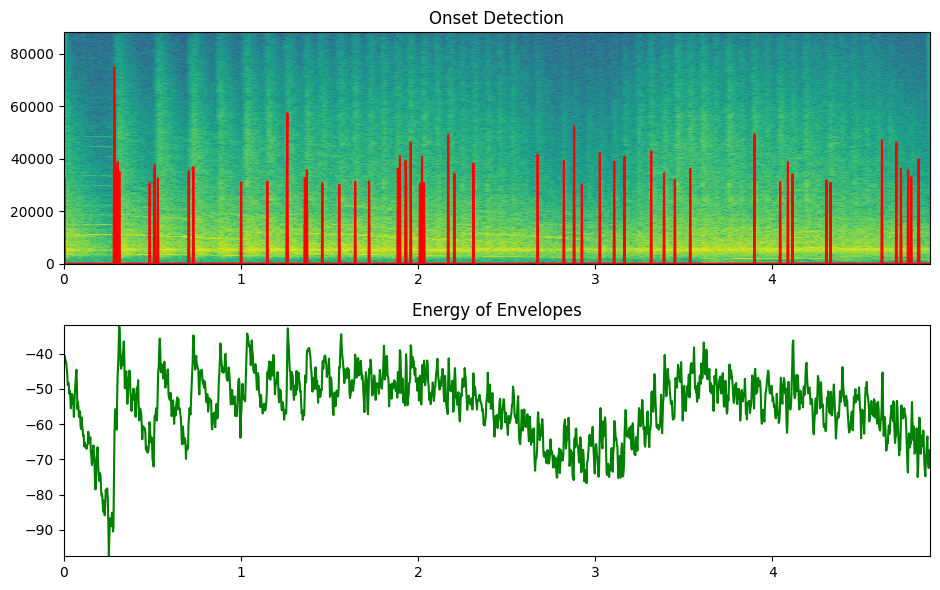

In [431]:
y, mY, odfs = hprModelAnal_odf_normal(x, fs, w, N, H, t, minSineDur, nH, minf0, maxf0, f0et, harmDevSlope)

## Conclusion:

As we can see from the analysis including the low pass filter and unique STFT parameters for the residual allows us to use a higher threshold for the ODF detection function that yields a more accurate result. This is because the sharper attacks and clearer frequency resultion by using a smaller window function for the anlaysis of the residuals allows for a more accurate energy computation and allows the peaks in the energy computation to become more pronounced. Also by removing the noise from the low to mid range frequencies it also allows for a clearer energy computation since there isnt as much noise affecting the energy computations making the peaks less pronounced. Overall the modifications to the functions resulted in a better analysis but the analysis is still not perfect.